In [346]:
%cd ~/src/laboratori/0506

/home/jovyan/src/laboratori/0506


# **Introduzione al Machine Learning -- laboratorio 5 e 6**

## Simulazione Monte Carlo

Problema 1: successione di uniformi [0,1] i.i.d. $U_i$

Facciamo le cumulate $S_i$. Data una soglia $a > 0$, sia $T$ il primo indice $i$ per cui $S_i$ supera $a$. Cerchiamo di stimare la media di $T$ e di studiare la sua distribuzione.

Imposta i parametri per una singola esecuzione della simulazione. Definisce la soglia `a`, calcola un orizzonte temporale `n` sufficientemente lungo, genera `n` numeri casuali uniformi `U` tra 0 e 1, e calcola la loro somma cumulativa `S`.

In [347]:
# Cominciamo con una simulazione sola

import numpy as np

a = 3.5
n = int(20 * a) # orizzonte temporale sufficiente

U = np.random.uniform(0, 1, n)
S = np.cumsum(U)

Visualizza i numeri casuali uniformi `U` generati e la loro somma cumulativa `S` utilizzando un grafico.

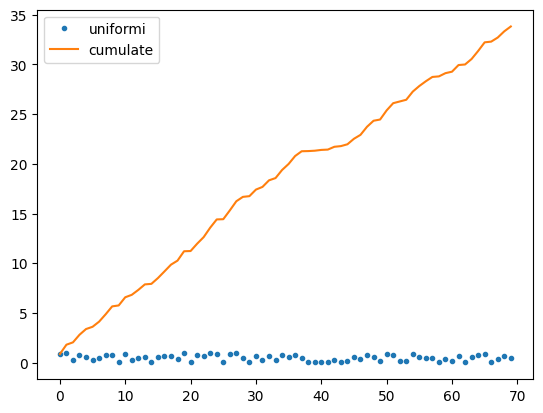

In [348]:
import matplotlib.pyplot as plt

plt.plot(U, '.', label='uniformi')
plt.plot(S, label='cumulate')
plt.legend()
plt.show()

Calcola il tempo di attesa `T`, definito come il primo indice `i` per cui la somma cumulativa `S_i` supera la soglia `a`. Stampa il valore di `T` calcolato.

In [349]:
T = np.sum(S < a) + 1
print(f'Tempo di attesa: {T}')

Tempo di attesa: 6


Mostra i primi 10 valori della somma cumulativa `S`.

In [350]:
S[0:10]

array([0.8687658 , 1.80439266, 2.04131975, 2.80524789, 3.38099154,
       3.60750541, 4.12411488, 4.86447502, 5.66026014, 5.75636248])

Esegue la simulazione Monte Carlo completa. Inizializza un array `T` per memorizzare i tempi di attesa di `N` simulazioni. Utilizza un approccio vettorizzato ottimizzato per generare `N` sequenze di numeri casuali uniformi, calcolare le loro somme cumulative e determinare il tempo di attesa `T` per ciascuna simulazione. Infine, verifica se qualche tempo di attesa ha superato l'orizzonte di simulazione `n`.

In [351]:
# Passiamo alla simulazione Monte Carlo vera e propria
N = 100000
T = np.zeros(N, dtype=int)

# for i in range(N):
#     U = np.random.uniform(0, 1, n)
#     S = np.cumsum(U)
#     T[i] = np.sum(S < a) + 1

# Versione ottimizzata senza loop
U_matrix = np.random.uniform(0, 1, (N, n))
S_matrix = np.cumsum(U_matrix, axis=1)
T = np.sum(S_matrix < a, axis=1) + 1

if T.max() > len(S):
    print('Attenzione: tempo di attesa troppo lungo!')
else:
    print(f'Massimo {T.max()} minore si {len(S)}')

Massimo 16 minore si 70


Calcola e visualizza le statistiche descrittive di base (massimo, minimo, media e deviazione standard) dei tempi di attesa `T` ottenuti dalla simulazione Monte Carlo.

In [352]:
T.max(), T.min(), T.mean(), T.std()

(np.int64(16),
 np.int64(4),
 np.float64(7.66569),
 np.float64(1.5901342156874685))

Calcola e stampa l'intervallo di confidenza per la media dei tempi di attesa `T`, utilizzando l'approssimazione della distribuzione normale. Definisce il livello di confidenza, calcola il quantile corrispondente e determina i limiti dell'intervallo.

In [353]:
# Vediamo la media, con una forbice di incertezza
from scipy.stats import norm

print(f'Mean: {T.mean()}')

media = T.mean()
conf = 0.95 # livello di confidenza
alpha = 1 - conf

q = norm.ppf((1 + conf) / 2) # uguale a (1 - alpha) / 2
St = T.std()
r = q * St / np.sqrt(N)

print(f'Quantile: {q}')
print(f'Standard deviation: {St}')
print(f'Incertezza: {r}')

print(f'Intervallo di confidenza al {conf}: [{media - r}, {media + r}]')

Mean: 7.66569
Quantile: 1.959963984540054
Standard deviation: 1.5901342156874685
Incertezza: 0.009855572875806032
Intervallo di confidenza al 0.95: [7.655834427124193, 7.675545572875806]


Visualizza la distribuzione dei tempi di attesa `T` simulati tramite un istogramma.

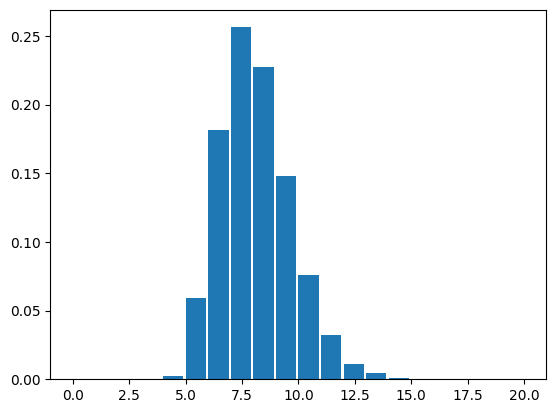

In [354]:
# Studiamo la distribuzione
plt.hist(T, bins=range(int(a * 6)), width=0.9, density=True)
plt.show()

Proviamo a fare un "fit" con una binomiale negativa. Ci sono vari metodi. Quello piu' elementare e' il metodo dei momenti.

Calcola la media campionaria, la deviazione standard, la varianza e l'eccesso di varianza dei tempi di attesa `T`. Osserva che un fit diretto con una distribuzione binomiale negativa non è possibile perché l'eccesso di varianza è negativo.

In [355]:
# Stimo i primi 2 momenti, perche' mi servono 2 parametri

nu = mu = T.mean()
sigma = T.std()
var = T.var()

ecc_var = (var - nu) / (nu ** 2)

print(f'Media: {mu}')
print(f'Standard deviation: {sigma}')
print(f'Varianza: {var}')
print(f'Eccesso di varianza: {ecc_var}')

# Ricavo i valori dei parametri di una binomiale negativa che corrispondono a quei momenti
# Non si puo' fittare con una negbin perche' `a` (i.e., `ecc_var`) e' negativo

Media: 7.66569
Standard deviation: 1.5901342156874685
Varianza: 2.5285268239000005
Eccesso di varianza: -0.08742202377080245


Tenta di adattare una distribuzione binomiale negativa dopo aver traslato i dati sottraendo il tempo di attesa minimo osservato `T_min`. Calcola la media e l'eccesso di varianza traslati, concludendo che l'adattamento non è ancora appropriato a causa della varianza troppo piccola.

In [356]:
# Riprovo, shiftando la distribuzione a sinistra in modo che si appoggi a zero
T_min = T.min()
nu_shift = nu - T_min
ecc_var_shift = (var - nu_shift) / (nu_shift ** 2)

print(f'Media: {mu}')
print(f'Standard deviation: {sigma}')
print(f'Varianza: {var}')
print(f'Eccesso di varianza: {ecc_var}')

# Niente da fare, la varianza e' troppo piccola

Media: 7.66569
Standard deviation: 1.5901342156874685
Varianza: 2.5285268239000005
Eccesso di varianza: -0.08742202377080245


Tenta di adattare una distribuzione binomiale (invece che binomiale negativa) ai tempi di attesa *traslati* utilizzando il metodo dei momenti. Calcola i parametri `p` (probabilità di successo) e `m` (numero di prove) basandosi sulla media e sulla varianza traslate.

In [357]:
from scipy.stats import binom

# Senza shiftare non funziona, viene `m` minore del massimo di T

# Metodo dei momenti: ricavo i due parametri della binomiale da media e varianza

p = 1 - (var / nu_shift)    # media: mp, varianza: mp(1-p), ricavo p dal rapporto
m = np.ceil(nu_shift / p)   # ricavo m dalla media e p, ma arrotondo

print(f"Probabilita': {p}")
print(f'Numero di successi: {m}')

Probabilita': 0.3102180424694939
Numero di successi: 12.0


Visualizza l'istogramma dei tempi di attesa traslati `T - T_min` e sovrappone la funzione di massa di probabilità (PMF) della distribuzione binomiale adattata per confronto.

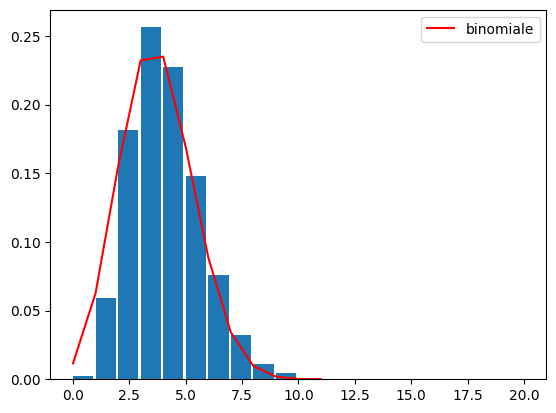

In [358]:
X_range = np.arange(0, m)

plt.hist(T - T_min, bins=range(int(a * 6)), width=0.9, density=True)
plt.plot(X_range, binom.pmf(X_range, m, p), 'r-', label='binomiale')
plt.legend()
plt.show()

Imposta i parametri (media `mu`, deviazione standard `sigma`) per una distribuzione normale e genera `N` campioni casuali `X` da essa.

Considero una legge Gaussiana $\mathcal N(\mu, \sigma^2)$, con $\mu\gg\sigma>0$ e stimo $E[\sqrt{X};X\geq0]$

In [359]:
mu = 100
sigma = 15

N = 1000
X = norm.rvs(loc=mu, scale=sigma, size=N)

Assicura che tutti i campioni generati `X` siano non negativi sostituendo i valori negativi con 0. Quindi, calcola la stima Monte Carlo di $E[\sqrt{X}]$ prendendo la media della radice quadrata dei campioni (non negativi).

In [360]:
X = np.maximum(X, 0) # non voglio valori negativi
stima = np.sqrt(X).mean()
print(f'Stima: {stima}')

Stima: 10.01351628389809


Calcola una stima più precisa di $E[\sqrt{X}]$ utilizzando l'integrazione numerica (`scipy.integrate.quad`). Definisce l'integrando (sqrt(x) * PDF della distribuzione normale) e lo integra da 0 a infinito. Stampa il valore stimato e l'errore di integrazione.

In [361]:
# Facciamo un integrale numerico, con la funzione quad
from scipy.integrate import quad

def integrand(x):
    return np.sqrt(x) * norm.pdf(x, loc=mu, scale=sigma)

stima, error = quad(integrand, 0, np.inf)

print(f'Stima: {stima}')
print(f'Incertezza: {error}')

# Fa meglio di una simulazione Monte Carlo

Stima: 9.971242544734102
Incertezza: 1.5368970920819874e-08


Esamina come la stima $E[\sqrt{X}]$ varia al variare del coefficiente di variazione (cv = sigma/mu). Definisce un intervallo di valori `cv` e calcola l'integrale per una distribuzione normale standardizzata (mu=1, sigma=cv) per ciascun `cv`. L'intervallo di integrazione viene adattato in base a `cv`.

In [362]:
# Al variare di mu e sigma

# Calcolo l'integrale in funzione di sigma/mu = cv (coefficiente di variazione)
cvs = np.geomspace(1e-4, 1, 100)

def integrand_cv(x, cv):
    return np.sqrt(x) * norm.pdf(x, loc=1.0, scale=cv)

stima = np.zeros_like(cvs)


for (i, cv) in enumerate(cvs):
    stima[i], _ = quad(integrand_cv, np.maximum(1-6*cv, 0), 1+6*cv, args=(cv,))


Visualizza le stime calcolate di $E[\sqrt{X}]$ (per mu=1) in funzione del coefficiente di variazione `cv`.

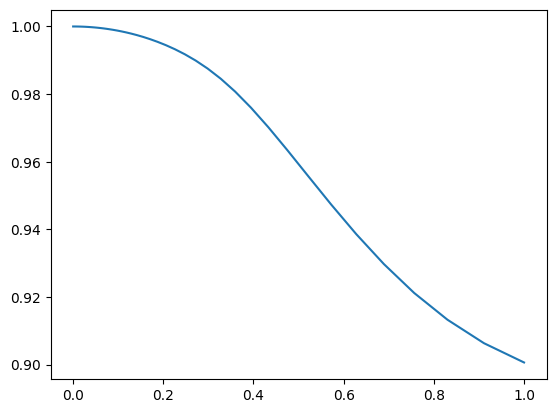

In [363]:
plt.plot(cvs, stima)
plt.show()

## Combinatoria nel Risiko (sort, reshape, `array[:,0,:]`, copy)

Calcola il numero totale di possibili esiti quando si lanciano 6 dadi a sei facce (3 per l'attaccante, 3 per il difensore).

In [364]:
# Numero di casi totali
max_cases = 6**6
print(max_cases)

46656


Definisce una funzione `to_base` che converte un intero `n` nella sua rappresentazione in una data `base` (predefinita 6) utilizzando un numero specificato di `digits` (predefinito 6). Questo viene utilizzato per generare le combinazioni dei lanci di dadi.

In [365]:
def to_base(n, base=6, digits=6):
  max_n = base**digits
  n = n % max_n # Tiene le ultime digits cifre e butta via le altre
  ret = []
  for i in range(digits):
    max_n = max_n // base
    ret.append(n // max_n)
    n = n % max_n
  return ret

Dimostra l'uso della funzione `to_base` convertendo un numero in base 10.

In [366]:
to_base(753648, 10, 8)

[0, 0, 7, 5, 3, 6, 4, 8]

Genera tutti i possibili esiti per 6 lanci di dadi. Itera da 0 a `max_cases - 1`, converte ogni numero in base 6 usando la funzione `to_base`, aggiunge 1 a ogni cifra (per rappresentare le facce del dado da 1 a 6) e memorizza i risultati in un array NumPy `cases`.

In [367]:
import numpy as np

cases = np.array([to_base(n) for n in range(max_cases)]) + 1
cases

array([[1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 2],
       [1, 1, 1, 1, 1, 3],
       ...,
       [6, 6, 6, 6, 6, 4],
       [6, 6, 6, 6, 6, 5],
       [6, 6, 6, 6, 6, 6]])

Visualizza la forma dell'array `cases`, confermando che contiene tutti i `max_cases` esiti con 6 valori di dado ciascuno.

In [368]:
cases.shape

(46656, 6)

Rimodella l'array `cases` per rappresentare coppie di 3 lanci di dadi (ad esempio, attaccante vs difensore), anche se il raggruppamento potrebbe non essere ancora conforme alle regole standard del Risiko.

In [369]:
cases.reshape((46656, 3, 2))

array([[[1, 1],
        [1, 1],
        [1, 1]],

       [[1, 1],
        [1, 1],
        [1, 2]],

       [[1, 1],
        [1, 1],
        [1, 3]],

       ...,

       [[6, 6],
        [6, 6],
        [6, 4]],

       [[6, 6],
        [6, 6],
        [6, 5]],

       [[6, 6],
        [6, 6],
        [6, 6]]])

Rimodella l'array `cases` in coppie di 3 lanci di dadi (attaccante, difensore) e visualizza il 12000° caso.

In [370]:
cases.reshape((-1, 2, 3))[12000]

array([[2, 4, 2],
       [4, 3, 1]])

Crea una copia dell'array `cases` per evitare di modificare i dati originali.

In [371]:
test = cases.copy()

Rimodella l'array copiato `test` in coppie di 3 lanci di dadi (attaccante, difensore).

In [372]:
test = test.reshape((-1, 2, 3))

Ordina i lanci di dadi all'interno di ogni set di 3 (sia per l'attaccante che per il difensore) in ordine crescente. Nota: le regole del Risiko utilizzano tipicamente l'ordine decrescente.

In [373]:
test.sort()

Visualizza il 12000° caso dopo aver ordinato i lanci di dadi all'interno di ciascun gruppo di 3.

In [374]:
test.reshape((-1, 2, 3))[12000]

array([[2, 2, 4],
       [1, 3, 4]])

Seleziona e visualizza i lanci di dadi per l'attaccante (primo set di 3 in ogni coppia) dopo l'ordinamento.

In [375]:
test[:,0,:] # attaccante

array([[1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       ...,
       [6, 6, 6],
       [6, 6, 6],
       [6, 6, 6]])

Confronta i lanci di dadi dell'attaccante (`test[:,0,:]`) con quelli del difensore (`test[:,1,:]`) elemento per elemento. Crea un array booleano `wins` che indica dove il dado dell'attaccante è strettamente maggiore del corrispondente dado del difensore. Nota: questo presuppone un confronto diretto dei dadi ordinati, che necessita di aggiustamenti per le regole effettive del Risiko (confronto tra il più alto vs il più alto, il secondo più alto vs il secondo più alto, ecc.).

In [376]:
wins = np.greater(test[:,0,:], test[:,1,:])
wins

array([[False, False, False],
       [False, False, False],
       [False, False, False],
       ...,
       [ True, False, False],
       [ True, False, False],
       [False, False, False]])

Calcola il numero di vittorie per l'attaccante in ogni combattimento simulato sommando i valori booleani nell'array `wins` lungo l'ultimo asse (axis=-1).

In [377]:
results = np.sum(wins, axis=-1)
results

array([0, 0, 0, ..., 1, 1, 0])

Conta quante volte l'attaccante ha vinto 0, 1, 2 o 3 confronti basandosi sull'array `results`. Memorizza questi conteggi in `res_cases`.

In [378]:
res_cases = [sum(results == i) for i in range(4)]
res_cases

[np.int64(17871), np.int64(12348), np.int64(10017), np.int64(6420)]

Calcola la probabilità che l'attaccante vinca 0, 1, 2 o 3 confronti dividendo i conteggi in `res_cases` per il numero totale di esiti possibili `max_cases`. Nota: queste probabilità si basano sulla logica di confronto semplificata utilizzata in precedenza e non rappresentano accuratamente gli esiti effettivi del combattimento nel Risiko senza ulteriori affinamenti (ordinamento decrescente, confronto dei primi N dadi).

In [379]:
np.array(res_cases) / max_cases

array([0.38303755, 0.26466049, 0.21469907, 0.13760288])